In [33]:
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import Planck18
from mpl_toolkits.mplot3d import Axes3D
import scipy
import pandas as pd

import limpy.lines as ll
import limpy.powerspectra as lp
import limpy.params as p
import limpy.utils as lu
#from limpy.plotsettings import *

import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np

In [2]:
import os
from astroquery import cache_conf
from astroquery.vizier import Vizier
print(Vizier.cache_location)
print(cache_conf.cache_active)
print(cache_conf.cache_timeout)

/Users/zengyulin/.astropy/cache/astroquery/Vizier
True
604800


In [3]:
from astroquery.simbad import Simbad
result_table = Simbad.query_object("m1")
result_table.pprint()

main_id    ra     dec   ... coo_wavelength     coo_bibcode     matched_id
          deg     deg   ...                                              
------- ------- ------- ... -------------- ------------------- ----------
  M   1 83.6324 22.0174 ...              X 2022A&A...661A..38P      M   1


In [4]:
from astropy import coordinates
import astropy.units as u
c = coordinates.SkyCoord("05h35m17.3s -05d23m28s", frame='icrs')
r = 5 * u.arcminute
result_table = Simbad.query_region(c, radius=r)
result_table.pprint(show_unit=True, max_width=80, max_lines=5)

          main_id                  ra       ...     coo_bibcode    
                                  deg       ...                    
---------------------------- -------------- ... -------------------
ALMA J053514.4142-052220.792  83.8100591667 ... 2023MNRAS.522...56V
                         ...            ... ...                 ...
     2MASS J05352445-0524010 83.85195950065 ... 2020yCat.1350....0G
                 [H97b] 9009 83.79990004111 ... 2020yCat.1350....0G
Length = 3324 rows


In [5]:
def extract_fits_data(file_path):
    """
    Extract RA, DEC, and Z columns from a FITS file.
    """
    with fits.open(file_path) as hdul:
        # Display information about the HDU list (optional)
        hdul.info()

        # Access the data from the first extension (BinTableHDU)
        data = hdul[1].data

        # Extract RA, DEC, and Z columns
        ra = data['RA']
        dec = data['DEC']
        z = data['Z']
        
    return ra, dec, z

# File paths
file_path_north = './data/galaxy_DR12v5_CMASSLOWZTOT_North.fits'
file_path_south = './data/galaxy_DR12v5_CMASSLOWZTOT_South.fits'

# Extract data from both files
ra1, dec1, z1 = extract_fits_data(file_path_north)
ra2, dec2, z2 = extract_fits_data(file_path_south)

# Combine the data into a single DataFrame (optional)
df_north = pd.DataFrame({'RA': ra1, 'DEC': dec1, 'Z': z1})
df_south = pd.DataFrame({'RA': ra2, 'DEC': dec2, 'Z': z2})

# Combine into one DataFrame if needed
df_combined = pd.concat([df_north, df_south], ignore_index=True)

# Save to CSV (optional)
df_combined.to_csv('combined_data.csv', index=False)

print("Data extraction complete. Combined data saved to 'combined_data.csv'.")

Filename: ./data/galaxy_DR12v5_CMASSLOWZTOT_North.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     92   953255R x 42C   [D, D, J, 12A, J, J, J, J, J, J, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, E, 5E, E, 5E, J, E, E, E, E, E, E, E, E, E, J, J, J, J, 3I, J, J, J, J]   
Filename: ./data/galaxy_DR12v5_CMASSLOWZTOT_South.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     92   372601R x 42C   [D, D, J, 12A, J, J, J, J, J, J, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, E, 5E, E, 5E, J, E, E, E, E, E, E, E, E, E, J, J, J, J, 3I, J, J, J, J]   
Data extraction complete. Combined data saved to 'combined_data.csv'.


In [6]:
print("Current working directory:", os.getcwd())

Current working directory: /Users/zengyulin/VS Code/2024_Physics_Hackthon


In [7]:
location_data = np.genfromtxt('combined_data.csv', skip_header=1, delimiter=',')
location_data = np.transpose(location_data)
ra = location_data[0] #phi = ra
dec = location_data[1] #theta = pi/2-dec
z1 = location_data[2]
# x = rsin(theta)cos(phi)
# y = rsin(theta)sin(phi)
# z = rcos(theta)

In [9]:
r = Planck18.comoving_distance(z1)

In [10]:
x = r*np.sin(np.pi/2-dec)*np.cos(ra)
y = r*np.sin(np.pi/2-dec)*np.sin(ra)
z = r*np.cos(np.pi/2-dec)

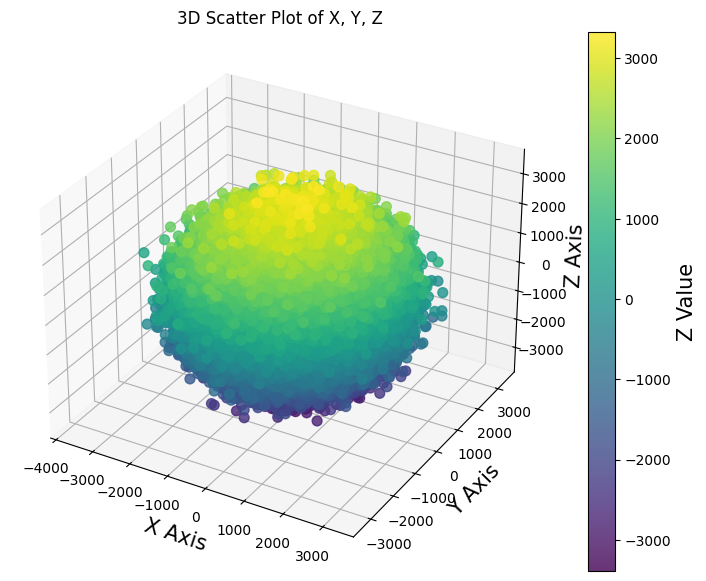

In [11]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o', s=50, alpha=0.8)
plt.colorbar(scatter, ax=ax, label="Z Value")

# Set labels
ax.set_title("3D Scatter Plot of X, Y, Z")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")

# Show plot
plt.show()

In [12]:
print(len(z))
#numpymeshgrib
#finufft

1325856


In [13]:
bin_x = np.linspace(np.min(x), np.max(x), 100 + 1)
bin_y = np.linspace(np.min(y), np.max(y), 100 + 1)
bin_z = np.linspace(np.min(z), np.max(z), 100 + 1)

In [14]:
hist, edges = np.histogramdd((x, y, z), bins= (bin_x, bin_y, bin_z))

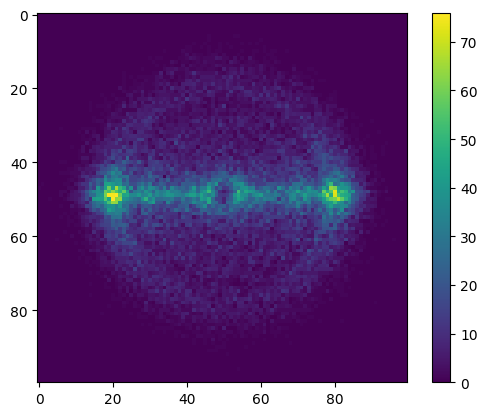

In [15]:
plt.imshow(hist[50])
plt.colorbar()

In [27]:
fourier = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(hist)))
power_spectrum = np.real(fourier*fourier.conj())

print(len(power_spectrum))
print(len(power_spectrum[0]))
print(len(power_spectrum[0][0]))

100
100
100


In [45]:
edge_x = edges[0]
bin_width_x = np.abs(edges[0][0]-edges[0][1])
fft_freqs_x = np.fft.fftshift(np.fft.fftfreq(len(edge_x) - 1, d=bin_width_x))

edge_y = edges[1]
bin_width_y = np.abs(edges[1][0]-edges[1][1])
fft_freqs_y = np.fft.fftshift(np.fft.fftfreq(len(edge_y) - 1, d=bin_width_y))

edge_z = edges[2]
bin_width_z = np.abs(edges[2][0]-edges[2][1])
fft_freqs_z= np.fft.fftshift(np.fft.fftfreq(len(edge_z) - 1, d=bin_width_z))

k_v = np.stack([edge_x, edge_y, edge_z])
k = np.sqrt(fft_freqs_x**2 + fft_freqs_y**2 + fft_freqs_z**2)


In [46]:
scipy.stats.binned_statistic_dd(power_spectrum, k, statistic='mean', bins=10)

ValueError: too many values to unpack (expected 2)

In [38]:
kx = fft_freqs_x.value
ky = fft_freqs_y.value
kz = fft_freqs_z.value

In [ ]:
sum_x = 

for x in range(power_spectrum.shape[0]:
    for y in range(power_spectrun.shape[1]:
        for z in range(power_spectrum.shape[2]:

            radius = (kx[x] ** 2 + ky[y]**2 + kz[z]**2)**0.5
            

In [40]:
kx.min()

np.float64(-0.007240099543189567)

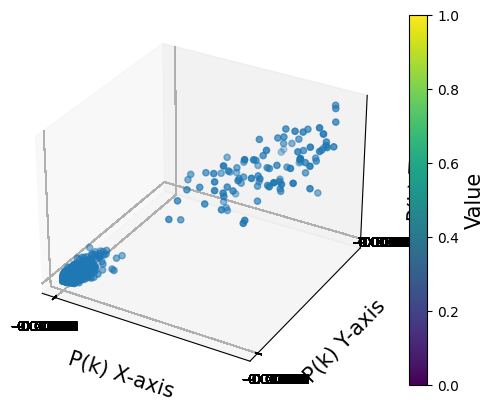

In [18]:
x = power_spectrum[0]
y = power_spectrum[1]
z = power_spectrum[2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z)
fig.colorbar(scatter, ax=ax, label='Value')

tick_indices = np.arange(0, len(fft_freqs_z), 10)
tick_indices = np.arange(0, len(fft_freqs_z), 10)
tick_indices = np.arange(0, len(fft_freqs_z), 10)

ax.set_xticks(fft_freqs_x.value)
ax.set_yticks(fft_freqs_y.value)
ax.set_zticks(fft_freqs_z.value)

ax.set_xlabel('P(k) X-axis')
ax.set_ylabel('P(k) Y-axis')
ax.set_zlabel('P(k) Z-axis')

plt.show()

In [19]:
print(edges) #fourier mode

[<Quantity [-3644.86357485, -3575.80375088, -3506.74392691, -3437.68410294,
           -3368.62427896, -3299.56445499, -3230.50463102, -3161.44480704,
           -3092.38498307, -3023.3251591 , -2954.26533512, -2885.20551115,
           -2816.14568718, -2747.0858632 , -2678.02603923, -2608.96621526,
           -2539.90639129, -2470.84656731, -2401.78674334, -2332.72691937,
           -2263.66709539, -2194.60727142, -2125.54744745, -2056.48762347,
           -1987.4277995 , -1918.36797553, -1849.30815156, -1780.24832758,
           -1711.18850361, -1642.12867964, -1573.06885566, -1504.00903169,
           -1434.94920772, -1365.88938374, -1296.82955977, -1227.7697358 ,
           -1158.70991182, -1089.65008785, -1020.59026388,  -951.53043991,
            -882.47061593,  -813.41079196,  -744.35096799,  -675.29114401,
            -606.23132004,  -537.17149607,  -468.11167209,  -399.05184812,
            -329.99202415,  -260.93220018,  -191.8723762 ,  -122.81255223,
             -53.7527282

In [20]:
plt.colorbar?

Signature:
plt.colorbar(
    mappable: 'ScalarMappable | None' = None,
    cax: 'matplotlib.axes.Axes | None' = None,
    ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None,
    **kwargs,
) -> 'Colorbar'
Docstring:
Add a colorbar to a plot.

Parameters
----------
mappable
    The `matplotlib.cm.ScalarMappable` (i.e., `.AxesImage`,
    `.ContourSet`, etc.) described by this colorbar.  This argument is
    mandatory for the `.Figure.colorbar` method but optional for the
    `.pyplot.colorbar` function, which sets the default to the current
    image.

    Note that one can create a `.ScalarMappable` "on-the-fly" to
    generate colorbars not attached to a previously drawn artist, e.g.
    ::

        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

cax : `~matplotlib.axes.Axes`, optional
    Axes into which the colorbar will be drawn.  If `None`, then a new
    Axes is created and the space for it will be stolen from the Axes(s)
    specified in *ax*.


In [21]:
ax.set_xticks?

Signature: ax.set_xticks(ticks, labels=None, *, minor=False, **kwargs)
Docstring:
Set the xaxis' tick locations and optionally tick labels.

If necessary, the view limits of the Axis are expanded so that all
given ticks are visible.

Parameters
----------
ticks : 1D array-like
    Array of tick locations (either floats or in axis units). The axis
    `.Locator` is replaced by a `~.ticker.FixedLocator`.

    Pass an empty list (``set_xticks([])``) to remove all ticks.

    Some tick formatters will not label arbitrary tick positions;
    e.g. log formatters only label decade ticks by default. In
    such a case you can set a formatter explicitly on the axis
    using `.Axis.set_major_formatter` or provide formatted
    *labels* yourself.

labels : list of str, optional
    Tick labels for each location in *ticks*; must have the same length as
    *ticks*. If set, the labels are used as is, via a `.FixedFormatter`.
    If not set, the labels are generated using the axis tick `.Formatter`